# TraitGym [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/songlab-cal/TraitGym/blob/main/TraitGym.ipynb)
In this example we will load the Mendelian traits dataset and run variant effect prediction based on euclidean distance of GPN-Animal-Promoter embeddings of the reference and alternate sequences.

## Setup

In [47]:
# !pip install -q pyfaidx s3fs git+https://github.com/songlab-cal/gpn.git
# !pip install -q -U transformers datasets

In [48]:
from Bio.Seq import Seq
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pybedtools as pbt
# import fsspec
# import gpn.model  # to register AutoModel
# import matplotlib.pyplot as plt
# import numpy as np
# import pandas as pd
# import polars as pl
# from pyfaidx import Fasta
# import seaborn as sns
# from sklearn.metrics import average_precision_score
# import torch
# import torch.nn.functional as F
# from transformers import AutoTokenizer, AutoModel, TrainingArguments, Trainer
# import tempfile

In [49]:
dataset_path = "songlab/TraitGym"
# dataset_config = "mendelian_traits"
dataset_config = "complex_traits"
model_path = "songlab/gpn-animal-promoter"
# in the paper we average with the predictions with the reverse complement
# however for a quick evaluation you can omit this
average_rc = False

## Load dataset

In [50]:
dataset = load_dataset(dataset_path, dataset_config, split="test")
dataset

Dataset({
    features: ['chrom', 'pos', 'ref', 'alt', 'pip', 'trait', 'label', 'maf', 'ld_score', 'consequence', 'tss_dist', 'match_group'],
    num_rows: 11400
})

In [51]:
dataset[0]

{'chrom': '1',
 'pos': 867476,
 'ref': 'C',
 'alt': 'T',
 'pip': 0.001559598385010465,
 'trait': '',
 'label': False,
 'maf': 0.079465,
 'ld_score': 44.053,
 'consequence': 'non_coding_transcript_exon_variant',
 'tss_dist': 56446,
 'match_group': 'non_coding_transcript_exon_variant_0'}

In [52]:
# if you just want a dataframe you can load it directly:
# pd.read_parquet("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/test.parquet")
V = dataset.to_pandas()
V

,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group
0,1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,56446,non_coding_transcript_exon_variant_0
1,1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,55870,non_coding_transcript_exon_variant_0
2,1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,55287,non_coding_transcript_exon_variant_0
3,1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,53746,non_coding_transcript_exon_variant_0
4,1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,18823,non_coding_transcript_exon_variant_1
...,...,...,...,...,...,...,...,...,...,...,...,...
11395,22,50368376,T,C,0.000000,,False,0.191810,86.507,dELS,3695,dELS_204
11396,22,50571623,C,T,0.000000,,False,0.061159,23.900,dELS,6291,dELS_202
11397,22,50671289,G,A,0.000000,,False,0.036223,12.733,pELS_flank,3125,pELS_flank_26
11398,22,50713837,C,G,0.000000,,False,0.060562,20.896,dELS,8340,dELS_202


## CRE

In [53]:
# get Encode CRE
!mkdir -p data
!wget https://downloads.wenglab.org/Registry-V4/GRCh38-cCREs.bed -O data/GRCh38-cCREs.bed

--2025-07-21 16:12:01--  https://downloads.wenglab.org/Registry-V4/GRCh38-cCREs.bed
Resolving downloads.wenglab.org (downloads.wenglab.org)... 146.189.25.27
Connecting to downloads.wenglab.org (downloads.wenglab.org)|146.189.25.27|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 129083055 (123M) [application/octet-stream]
Saving to: ‘data/GRCh38-cCREs.bed’

data/GRCh38-cCREs.b 100%[===================>] 123.10M  24.8MB/s    in 5.8s    

2025-07-21 16:12:08 (21.3 MB/s) - ‘data/GRCh38-cCREs.bed’ saved [129083055/129083055]



In [54]:
!head data/GRCh38-cCREs.bed

chr1	10033	10250	EH38D4327497	EH38E2776516	pELS
chr1	10385	10713	EH38D4327498	EH38E2776517	pELS
chr1	16097	16381	EH38D6144701	EH38E3951272	CA-CTCF
chr1	17343	17642	EH38D6144702	EH38E3951273	CA-TF
chr1	29320	29517	EH38D6144703	EH38E3951274	CA
chr1	66350	66509	EH38D4327503	EH38E3951275	CA
chr1	78990	79238	EH38D4327504	EH38E3951276	CA
chr1	79304	79545	EH38D4327505	EH38E2776519	dELS
chr1	91087	91426	EH38D6144707	EH38E3951277	CA-CTCF
chr1	98867	99117	EH38F0000001	EH38E3951278	TF


In [55]:
import pybedtools as pbt
V1 = V.copy()
V1["chrom"] = V1["chrom"].apply(lambda x: "chr" + x)
V1["end"] = V1["pos"] + 1
variants = pbt.BedTool.from_dataframe(V1.reset_index().rename(columns={"index": "ind"})[
	["chrom","pos","end","ind"]
	])
variants.head()

chr1	867476	867477	0
 chr1	868052	868053	1
 chr1	868635	868636	2
 chr1	870176	870177	3
 chr1	1052930	1052931	4
 chr1	1359031	1359032	5
 chr1	1704180	1704181	6
 chr1	1989803	1989804	7
 chr1	2293397	2293398	8
 chr1	2299360	2299361	9
 

In [56]:
CRE = pbt.BedTool("data/GRCh38-cCREs.bed")
CRE.head()

chr1	10033	10250	EH38D4327497	EH38E2776516	pELS
 chr1	10385	10713	EH38D4327498	EH38E2776517	pELS
 chr1	16097	16381	EH38D6144701	EH38E3951272	CA-CTCF
 chr1	17343	17642	EH38D6144702	EH38E3951273	CA-TF
 chr1	29320	29517	EH38D6144703	EH38E3951274	CA
 chr1	66350	66509	EH38D4327503	EH38E3951275	CA
 chr1	78990	79238	EH38D4327504	EH38E3951276	CA
 chr1	79304	79545	EH38D4327505	EH38E2776519	dELS
 chr1	91087	91426	EH38D6144707	EH38E3951277	CA-CTCF
 chr1	98867	99117	EH38F0000001	EH38E3951278	TF
 

In [57]:
intersected = variants.intersect(CRE, wa=True, wb=True)
intersected.head()

chr1	870176	870177	3	chr1	870120	870448	EH38D2115380	EH38E1310196	PLS
 chr1	1704180	1704181	6	chr1	1704031	1704228	EH38D4329339	EH38E2777860	CA-CTCF
 chr1	1989803	1989804	7	chr1	1989683	1989857	EH38D4329844	EH38E2778173	dELS
 chr1	2293397	2293398	8	chr1	2293066	2293408	EH38D4330458	EH38E2778685	dELS
 chr1	2299360	2299361	9	chr1	2299316	2299666	EH38D2117314	EH38E1311761	dELS
 chr1	2392128	2392129	11	chr1	2391934	2392163	EH38D4330666	EH38E2778855	PLS
 chr1	2409065	2409066	12	chr1	2408922	2409265	EH38D4330700	EH38E2778882	dELS
 chr1	2416601	2416602	13	chr1	2416330	2416667	EH38D4330717	EH38E2778898	dELS
 chr1	2869701	2869702	14	chr1	2869628	2869947	EH38D4331467	EH38E2779374	CA-H3K4me3
 chr1	2878207	2878208	15	chr1	2878110	2878359	EH38D4331477	EH38E2779380	CA-H3K4me3
 

In [58]:
CRE_types = intersected.to_dataframe()[["chrom","start","end","name","blockCount"]].rename(columns={
	"chrom": "chrom",
	"start": "pos",
	"end": "end",
	"name": "ind",
	"blockCount": "CRE_type"
})
CRE_types.head()

,chrom,pos,end,ind,CRE_type
0,chr1,870176,870177,3,PLS
1,chr1,1704180,1704181,6,CA-CTCF
2,chr1,1989803,1989804,7,dELS
3,chr1,2293397,2293398,8,dELS
4,chr1,2299360,2299361,9,dELS


In [59]:
V2 = V1.reset_index().rename(columns={"index": "ind"}).merge(CRE_types, on=["chrom","pos","end","ind"], how="left")
# convert nan to 0
V2["CRE_type"] = V2["CRE_type"].fillna(0)
V2.head()

,ind,chrom,pos,ref,alt,pip,trait,label,maf,ld_score,consequence,tss_dist,match_group,end,CRE_type
0,0,chr1,867476,C,T,0.001560,,False,0.079465,44.053,non_coding_transcript_exon_variant,56446,non_coding_transcript_exon_variant_0,867477,0
1,1,chr1,868052,T,C,0.001791,,False,0.077747,44.057,non_coding_transcript_exon_variant,55870,non_coding_transcript_exon_variant_0,868053,0
2,2,chr1,868635,A,G,0.004349,,False,0.075255,43.639,non_coding_transcript_exon_variant,55287,non_coding_transcript_exon_variant_0,868636,0
3,3,chr1,870176,T,A,0.000000,,False,0.084371,37.271,non_coding_transcript_exon_variant,53746,non_coding_transcript_exon_variant_0,870177,PLS
4,4,chr1,1052930,A,G,0.001467,,False,0.058385,46.907,non_coding_transcript_exon_variant,18823,non_coding_transcript_exon_variant_1,1052931,0


In [60]:
# Compute CRE_type value counts aggregating by label
cre_label_counts = V2.groupby(["CRE_type", "label"]).size().unstack(fill_value=0)
# normalize by column sum
cre_label_counts = cre_label_counts.div(cre_label_counts.sum(axis=0), axis=1)
cre_label_counts

label,False,True
CRE_type,,
0,0.462865,0.391228
CA,0.012281,0.012281
CA-CTCF,0.004971,0.004386
CA-H3K4me3,0.005263,0.009649
CA-TF,0.001170,0.000877
PLS,0.049708,0.061404
TF,0.010136,0.005263
dELS,0.340156,0.394737
pELS,0.113450,0.120175


## ADASTRA

In [61]:
# !wget https://zenodo.org/records/14174114/files/ADASTRA.v.6.1.Mabel.zip?download=1 -O data/ADASTRA.v.6.1.Mabel.zip
# !unzip data/ADASTRA.v.6.1.Mabel.zip -d data/ADASTRA.v.6.1.Mabel/
# !head data/ADASTRA.v.6.1.Mabel/CL/10326__NMC__French_et_al__2008_.tsv

In [62]:
adastra = pbt.BedTool("data/ADASTRA.v.6.1.Mabel/CL/10326__NMC__French_et_al__2008_.tsv").sort()
adastra.head()

chr14	22268380	22268381	rs6572350	T	G	LTR	1.0	82.0	1	21	0.404	0.113	0.6852506052976998	0.7272609265505803
 chr14	22268492	22268493	rs12880936	C	T	LTR	1.0	82.0	1	22	0.264	0.311	0.6852506052976998	0.706055121320338
 chr14	22269105	22269106	rs8011203	C	T	LTR	1.0	82.0	1	21	1.02	-0.629	0.5895163207859102	0.8769156279219065
 chr14	22269826	22269827	rs2187652	C	T		1.0	82.0	1	24	-0.02	0.659	0.7404804942569662	0.706055121320338
 chr14	22269831	22269832	rs2187653	A	C		1.0	82.0	1	24	-0.02	0.659	0.7404804942569662	0.706055121320338
 chr14	22273145	22273146	rs17255654	C	T	LTR	1.0	82.0	1	21	-1.103	1.331	0.9489915431597395	0.503615342268832
 chr14	22273292	22273293	rs72688496	G	C	LTR	1.0	82.0	1	20		1.697	1.0	0.4051671208776345
 chr14	22273536	22273537	rs12586149	G	A	LTR	1.0	82.0	1	24	-0.361	0.947	0.8143815961055574	0.6275204750961062
 chr14	22273850	22273851	rs3811272	C	T		1.0	82.0	1	20	-0.538	0.888	0.8382131328957916	0.6275204750961062
 chr14	22284178	22284179	rs56026044	A	G	LINE	1.0	82.0	1	24	0.306

In [153]:
import glob
import os
import pandas as pd
from tqdm import tqdm

# Get all tsv files in the directory
adastra_tsv_files = glob.glob("data/ADASTRA.v.6.1.Mabel/CL/*.tsv")
cols = open(adastra_tsv_files[0]).readline().strip().split("\t")
cols[0] = cols[0].replace("#", "")
print (cols)

# Read and concatenate all files, adding filename as a column
_ = None
for file in tqdm(adastra_tsv_files):
	df = pd.read_csv(file, sep="\t", comment="#", header=None, names=cols)

	# this file is 0-based, while variants in traitgym are 1-based
	df["start"] += 1
	df["end"] += 1
	df = df.merge(V1[["chrom","pos","ref","label","alt"]], left_on=["chr","start","alt"], right_on=["chrom","pos","alt"], how="inner")
	assert all(df["ref_x"] == df["ref_y"])
	df = df.drop(columns=["ref_y"])
	df = df.rename(columns={"ref_x": "ref"})
	df["source_file"] = os.path.basename(file)
	# df.query("fdrp_bh_ref < 0.2 or fdrp_bh_alt < 0.2", inplace=True)
	if _ is None:
		_ = df
	else:
		_ = pd.concat([_, df], ignore_index=True)

adastra_all = _
adastra_all.head()

['chr', 'start', 'end', 'ID', 'ref', 'alt', 'repeat_type', 'mean_BAD', 'mean_SNP_per_segment', 'n_aggregated', 'total_cover', 'es_mean_ref', 'es_mean_alt', 'fdrp_bh_ref', 'fdrp_bh_alt']


100%|██████████| 659/659 [02:41<00:00,  4.08it/s]


,chr,start,end,ID,ref,alt,repeat_type,mean_BAD,mean_SNP_per_segment,n_aggregated,total_cover,es_mean_ref,es_mean_alt,fdrp_bh_ref,fdrp_bh_alt,chrom,pos,label,source_file
0,chr1,153658595,153658596,rs3806234,G,A,NaN,3.0,119.0,1,27,0.632,-0.096,0.735343,0.829577,chr1,153658595,True,CHLA-90__neuroblastoma_.tsv
1,chr1,156054582,156054583,rs3754293,A,G,NaN,3.0,119.0,1,21,-0.195,0.533,0.818839,0.778123,chr1,156054582,False,CHLA-90__neuroblastoma_.tsv
2,chr1,167721830,167721831,rs4142140,C,A,NaN,3.0,119.0,1,23,0.080,0.342,0.737482,0.778123,chr1,167721830,False,CHLA-90__neuroblastoma_.tsv
3,chr10,4662852,4662853,rs45608837,A,G,DNA,2.0,161.0,1,20,-0.183,0.553,0.785853,0.778123,chr10,4662852,False,CHLA-90__neuroblastoma_.tsv
4,chr9,126082810,126082811,rs16928653,C,T,NaN,1.0,88.0,1,85,0.049,-0.049,0.746464,0.829577,chr9,126082810,False,CHLA-90__neuroblastoma_.tsv


In [155]:
adastra_all.to_csv("adastra_all.tsv", sep="\t", index=False)

In [156]:
adastra_all

,chr,start,end,ID,ref,alt,repeat_type,mean_BAD,mean_SNP_per_segment,n_aggregated,total_cover,es_mean_ref,es_mean_alt,fdrp_bh_ref,fdrp_bh_alt,chrom,pos,label,source_file
0,chr1,153658595,153658596,rs3806234,G,A,NaN,3.0,119.0,1,27,0.632,-0.096,0.735343,0.829577,chr1,153658595,True,CHLA-90__neuroblastoma_.tsv
1,chr1,156054582,156054583,rs3754293,A,G,NaN,3.0,119.0,1,21,-0.195,0.533,0.818839,0.778123,chr1,156054582,False,CHLA-90__neuroblastoma_.tsv
2,chr1,167721830,167721831,rs4142140,C,A,NaN,3.0,119.0,1,23,0.080,0.342,0.737482,0.778123,chr1,167721830,False,CHLA-90__neuroblastoma_.tsv
3,chr10,4662852,4662853,rs45608837,A,G,DNA,2.0,161.0,1,20,-0.183,0.553,0.785853,0.778123,chr10,4662852,False,CHLA-90__neuroblastoma_.tsv
4,chr9,126082810,126082811,rs16928653,C,T,NaN,1.0,88.0,1,85,0.049,-0.049,0.746464,0.829577,chr9,126082810,False,CHLA-90__neuroblastoma_.tsv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38423,chr21,42286834,42286835,rs450808,T,C,NaN,1.0,96.0,1,21,-0.293,0.759,0.784996,0.729839,chr21,42286834,False,pre-B_acute_lymphoblastic_leukemia.tsv
38424,chr22,36862461,36862462,rs4821544,T,C,NaN,1.0,79.0,1,20,0.206,0.247,0.696791,0.785880,chr22,36862461,True,pre-B_acute_lymphoblastic_leukemia.tsv
38425,chr3,72345701,72345702,rs61192126,T,C,LINE,1.0,252.0,1,21,0.066,0.445,0.704249,0.785880,chr3,72345701,True,pre-B_acute_lymphoblastic_leukemia.tsv
38426,chr3,72348128,72348129,rs9809116,A,G,NaN,1.0,252.0,2,44,2.071,-1.984,0.112012,1.000000,chr3,72348128,True,pre-B_acute_lymphoblastic_leukemia.tsv


<Axes: xlabel='es_mean_ref', ylabel='es_mean_alt'>

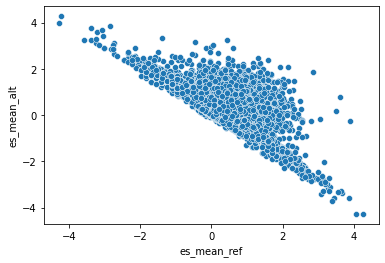

In [157]:
import seaborn as sns
sns.scatterplot(adastra_all.query("mean_BAD == 1.0"), x="es_mean_ref", y="es_mean_alt")

<Axes: xlabel='es_mean_ref', ylabel='fdrp_bh_ref'>

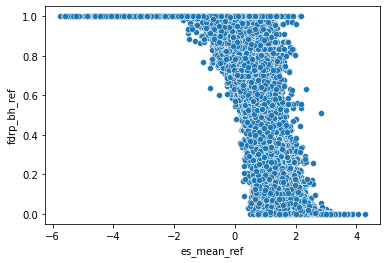

In [158]:
sns.scatterplot(data=adastra_all, x="es_mean_ref", y="fdrp_bh_ref")

In [171]:
tqdm.pandas()
# adastra_all = adastra_all.iloc[:100]
adastra_all["ASEdiff"] = abs(adastra_all["es_mean_ref"] - adastra_all["es_mean_alt"])
adastra_all[["comb_es","fdr_comb_pval", "ASE_best_allele_source"]] = adastra_all.progress_apply(
	lambda x: pd.Series({"comb_es":x["es_mean_ref"], "fdr_comb_pval":x["fdrp_bh_ref"], "ASE_best_allele_source":"ref"}) \
		if x["fdrp_bh_ref"] < x["fdrp_bh_alt"] else \
			pd.Series({"comb_es":x["es_mean_alt"], "fdr_comb_pval":x["fdrp_bh_alt"], "ASE_best_allele_source":"alt"}), axis=1
)

100%|██████████| 38428/38428 [00:10<00:00, 3507.14it/s]


In [179]:
field =  "fdr_comb_pval" #"comb_es" #"max_cover" #"fdr_comb_pval" #"comb_es"
higher_is_better = False

	# query("fdr_comb_pval < 0.05").\

subset = adastra_all.\
	sort_values(by=["chr", "start", "end", "alt", field], ascending=[True, True, True, True, not higher_is_better]).\
	drop_duplicates(subset=["chr","start","end","alt"], keep="first")

subset.head()

,chr,start,end,ID,ref,alt,repeat_type,mean_BAD,mean_SNP_per_segment,n_aggregated,...,fdrp_bh_ref,fdrp_bh_alt,chrom,pos,label,source_file,ASEdiff,comb_es,fdr_comb_pval,ASE_best_allele_source
9266,chr1,870176,870177,rs72631880,T,A,NaN,3.0,77.7,3,...,0.144127,1.000000,chr1,870176,False,KMS-11__Plasma_cell_myeloma_.tsv,2.208,1.380,0.144127,ref
29501,chr1,1989803,1989804,rs13303156,A,G,NaN,2.0,19435.0,2,...,0.738935,0.810756,chr1,1989803,False,HT1080__fibrosarcoma_.tsv,0.533,0.401,0.738935,ref
24986,chr1,2293397,2293398,rs12743493,G,A,NaN,1.5,3614.0,1,...,0.836128,0.881183,chr1,2293397,True,BT-549__breast_invasive_ductal_carcinoma_.tsv,0.503,-0.181,0.836128,ref
29360,chr1,2299360,2299361,rs10797419,T,C,NaN,2.0,191.0,3,...,0.263331,1.000000,chr1,2299360,False,macrophages_form_periferal_blood.tsv,1.099,0.872,0.263331,ref
15471,chr1,2315482,2315483,rs139971383,C,G,NaN,2.0,366.0,2,...,0.001149,1.000000,chr1,2315482,False,primary_B-CLL_cells.tsv,NaN,2.579,0.001149,ref


In [180]:
print(subset["label"].value_counts())
print(subset["label"].value_counts(normalize=True))

False    6024
True      762
Name: label, dtype: int64
False    0.88771
True     0.11229
Name: label, dtype: float64


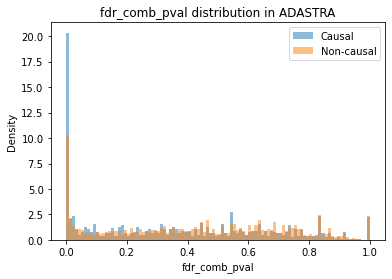

In [181]:
# if field == "fdr_comb_pval":
# 	subset["fdr_comb_pval"] = subset["fdr_comb_pval"].clip(lower=0.5)

plt.hist(subset.query("label == True")[field], density=True, bins=100, label="Causal", alpha=0.5)
plt.hist(subset.query("label == False")[field], density=True, bins=100, label="Non-causal", alpha=0.5)
plt.xlabel(field)
plt.ylabel("Density")
# plt.xscale("log")
plt.title(f"{field} distribution in ADASTRA")
plt.legend()
plt.show()

# old version of adastra

In [121]:
tqdm.pandas()
# adastra_all = adastra_all.iloc[:100]
adastra_all["ASEdiff"] = abs(adastra_all["es_mean_ref"] - adastra_all["es_mean_alt"])
adastra_all[["ASE_best","ASE_best_fdr", "ASE_best_allele_source"]] = adastra_all.progress_apply(
	lambda x: pd.Series({"ASE_best":x["es_mean_ref"], "ASE_best_fdr":x["fdrp_bh_ref"], "ASE_best_allele_source":"ref"}) \
		if x["fdrp_bh_ref"] < x["fdrp_bh_alt"] else \
			pd.Series({"ASE_best":x["es_mean_alt"], "ASE_best_fdr":x["fdrp_bh_alt"], "ASE_best_allele_source":"alt"}), axis=1
)

100%|██████████| 906415/906415 [04:53<00:00, 3083.66it/s]


In [125]:
adastra_all.sort_values(by=["chr","start","end","ASE_best"], ascending=[True, True, True, False])

,chr,start,end,ID,ref,alt,repeat_type,mean_BAD,mean_SNP_per_segment,n_aggregated,total_cover,es_mean_ref,es_mean_alt,fdrp_bh_ref,fdrp_bh_alt,source_file,ASEdiff,ASE_best,ASE_best_fdr,ASE_best_allele_source
803439,chr1,629906,629907,rs1578391,C,T,NaN,1.00,156.0,1,24,-1.976,1.970,0.990505,1.345265e-01,Akata-Zta__cell_line_infected_by_Epstein-Barr_...,3.946,1.970,1.345265e-01,alt
268663,chr1,629906,629907,rs1578391,C,T,NaN,1.50,672.0,1,28,NaN,1.893,1.000000,7.747701e-02,GM12878__female_B-cells_lymphoblastoid_cell_li...,NaN,1.893,7.747701e-02,alt
42668,chr1,629906,629907,rs1578391,C,T,NaN,1.00,320.0,1,20,NaN,1.697,1.000000,1.342225e-01,LUHMES__lund_human_mesencephalic_cells_.tsv,NaN,1.697,1.342225e-01,alt
478816,chr1,629906,629907,rs1578391,C,T,NaN,1.00,134.0,2,38,-1.243,1.295,1.000000,1.587671e-01,CRC107__colorectal_cancer_metastatic_stem_cell...,2.538,1.295,1.587671e-01,alt
268664,chr1,629915,629916,rs538388406,A,G,NaN,1.20,281.0,5,161,-1.691,2.591,1.000000,3.196351e-10,GM12878__female_B-cells_lymphoblastoid_cell_li...,4.282,2.591,3.196351e-10,alt
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374972,chrX,155999818,155999819,rs3093470,C,T,NaN,2.00,1772.0,1,43,-1.385,2.437,0.992570,1.230001e-01,MCF10A__breast_epithelial_cells_.tsv,3.822,2.437,1.230001e-01,alt
21057,chrX,156009119,156009120,rs111066114,G,C,Simple_repeat,2.24,888.8,154,16293,0.355,2.321,1.000000,2.134232e-248,HEK293__embryonic_kidney_.tsv,1.966,2.321,2.134232e-248,alt
383517,chrX,156009119,156009120,rs111066114,G,C,Simple_repeat,2.62,2403.5,16,937,0.462,1.854,1.000000,9.651196e-07,HEK293T__embryonic_kidney_.tsv,1.392,1.854,9.651196e-07,alt
318583,chrX,156009119,156009120,rs111066114,G,C,Simple_repeat,2.39,494.0,38,1898,0.718,1.831,1.000000,8.189998e-16,GM12878__female_B-cells_lymphoblastoid_cell_li...,1.113,1.831,8.189998e-16,alt


In [126]:
print (f"len of adastra_all: {len(adastra_all)}")
adastra_filtered = adastra_all.query("ASE_best_fdr < 0.1").\
	sort_values(by=["chr","start","end","ASE_best"], ascending=[True, True, True, False]).\
	drop_duplicates(subset=["chr","start","end","ref","alt"], keep="first").\
	reset_index(drop=True)
adastra_filtered.to_csv("adastra_filtered.tsv", sep="\t", index=False)
print (f"len of adastra_filtered: {len(adastra_filtered)}")

len of adastra_all: 906415
len of adastra_filtered: 321614


In [127]:
adastra_filtered

,chr,start,end,ID,ref,alt,repeat_type,mean_BAD,mean_SNP_per_segment,n_aggregated,total_cover,es_mean_ref,es_mean_alt,fdrp_bh_ref,fdrp_bh_alt,source_file,ASEdiff,ASE_best,ASE_best_fdr,ASE_best_allele_source
0,chr1,629906,629907,rs1578391,C,T,NaN,1.50,672.0,1,28,NaN,1.893,1.000000,7.747701e-02,GM12878__female_B-cells_lymphoblastoid_cell_li...,NaN,1.893,7.747701e-02,alt
1,chr1,629915,629916,rs538388406,A,G,NaN,1.20,281.0,5,161,-1.691,2.591,1.000000,3.196351e-10,GM12878__female_B-cells_lymphoblastoid_cell_li...,4.282,2.591,3.196351e-10,alt
2,chr1,629963,629964,rs41485244,A,G,NaN,2.00,95.0,1,50,2.667,-4.894,0.004041,1.000000e+00,neutrophils_from_periferal_blood.tsv,7.561,2.667,4.041333e-03,ref
3,chr1,778597,778598,rs74512038,C,T,NaN,2.50,116.0,2,106,2.100,NaN,0.002438,1.000000e+00,monocytes_from_periferal_blood.tsv,NaN,2.100,2.438490e-03,ref
4,chr1,778639,778640,rs114983708,A,G,NaN,2.00,20.0,2,365,0.984,0.745,0.015396,5.510306e-01,GM19238__female_B-cells_lymphoblastoid_cell_li...,0.239,0.984,1.539647e-02,ref
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
321609,chrX,155872925,155872926,rs115460807,G,C,SINE,2.00,5309.0,1,45,2.824,-5.339,0.010582,1.000000e+00,22RV1__prostate_carcinoma_.tsv,8.163,2.824,1.058162e-02,ref
321610,chrX,155881414,155881415,rs28413172,C,T,NaN,2.00,329.0,2,61,2.582,-0.966,0.025481,1.000000e+00,breast_tumor.tsv,3.548,2.582,2.548090e-02,ref
321611,chrX,155938281,155938282,rs5983836,C,T,LINE,2.50,4.0,1,78,NaN,2.350,1.000000,7.518060e-03,MS-1__Small_cell_lung_carcinoma_.tsv,NaN,2.350,7.518060e-03,alt
321612,chrX,155966865,155966866,rs5983842,A,G,LINE,1.75,33.5,2,72,-1.095,1.855,1.000000,2.475225e-02,LNCaP__prostate_carcinoma_.tsv,2.950,1.855,2.475225e-02,alt


In [128]:
adastra_filtered[["chr","start","end"]].reset_index()

,index,chr,start,end
0,0,chr1,629906,629907
1,1,chr1,629915,629916
2,2,chr1,629963,629964
3,3,chr1,778597,778598
4,4,chr1,778639,778640
...,...,...,...,...
321609,321609,chrX,155872925,155872926
321610,321610,chrX,155881414,155881415
321611,321611,chrX,155938281,155938282
321612,321612,chrX,155966865,155966866


<Axes: >

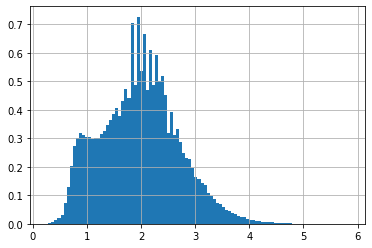

In [146]:
adastra_filtered["ASE_best"].hist(bins=100, density=True)

In [ ]:
bt = pbt.BedTool.from_dataframe(adastra_filtered.reset_index()[["chr","start","end","index"]])
bt = bt.sort().intersect(
	pbt.BedTool.from_dataframe(V1.reset_index()[["chrom","pos","end","index"]]).sort(), 
	wa=True, wb=True)
print (f"Out of {len(adastra_filtered)} ADSTRA variants, {len(bt)} overlap with the V1 dataset")
bt.head()
# For 100 first adastra files: Out of 53899 ADSTRA variants, 272 overlap with the V1 dataset
# For all adastra files: Out of 321614 ADSTRA variants, 1406 overlap with the V1 dataset

Out of 321614 ADSTRA variants, 1406 overlap with the V1 dataset
chr1	2315482	2315483	506	chr1	2315482	2315483	10
 chr1	3409624	3409625	672	chr1	3409624	3409625	19
 chr1	3543648	3543649	713	chr1	3543648	3543649	22
 chr1	3774964	3774965	796	chr1	3774964	3774965	26
 chr1	6058884	6058885	1080	chr1	6058884	6058885	35
 chr1	6236178	6236179	1113	chr1	6236178	6236179	42
 chr1	9315952	9315953	1814	chr1	9315952	9315953	63
 chr1	9362918	9362919	1822	chr1	9362918	9362919	64
 chr1	9433231	9433232	1845	chr1	9433231	9433232	66
 chr1	10211630	10211631	1975	chr1	10211630	10211631	70
 

In [131]:
bt.to_dataframe()
# first 3 cols are from adastra, next 3 cols are from traitgym variants

,chrom,start,end,name,score,strand,thickStart,thickEnd
0,chr1,2315482,2315483,506,chr1,2315482,2315483,10
1,chr1,3409624,3409625,672,chr1,3409624,3409625,19
2,chr1,3543648,3543649,713,chr1,3543648,3543649,22
3,chr1,3774964,3774965,796,chr1,3774964,3774965,26
4,chr1,6058884,6058885,1080,chr1,6058884,6058885,35
...,...,...,...,...,...,...,...,...
1401,chr9,135443946,135443947,318735,chr9,135443946,135443947,5649
1402,chr9,135500019,135500020,318743,chr9,135500019,135500020,5650
1403,chr9,137119036,137119037,319221,chr9,137119036,137119037,5672
1404,chr9,137205772,137205773,319246,chr9,137205772,137205773,5674


In [132]:
merged_bt = bt.to_dataframe() # first 3 cols are from adastra, next 3 cols are from traitgym variants
assert all(merged_bt["chrom"] == merged_bt["score"])
assert all(merged_bt["start"] == merged_bt["strand"])
assert all(merged_bt["end"] == merged_bt["thickStart"])
merged_bt = merged_bt[["chrom","start","end","name","thickEnd"]].rename(columns={"name":"adastra_index", 
																				"thickEnd":"traitgym_index"}
																				)
merged_bt

,chrom,start,end,adastra_index,traitgym_index
0,chr1,2315482,2315483,506,10
1,chr1,3409624,3409625,672,19
2,chr1,3543648,3543649,713,22
3,chr1,3774964,3774965,796,26
4,chr1,6058884,6058885,1080,35
...,...,...,...,...,...
1401,chr9,135443946,135443947,318735,5649
1402,chr9,135500019,135500020,318743,5650
1403,chr9,137119036,137119037,319221,5672
1404,chr9,137205772,137205773,319246,5674


In [140]:
# now combine them as datasets
variants_annotated = V1.reset_index()
variants_annotated = variants_annotated.merge(merged_bt, 
											left_on=["chrom","pos","end","index"], 
											right_on=["chrom","start","end","traitgym_index"], 
											how="right",
											validate="one_to_one"
											)
variants_annotated
											
variants_annotated = variants_annotated.drop(columns=["index"]).merge(
											adastra_filtered.reset_index(),
											left_on=["chrom","pos","end","adastra_index","ref"],
											right_on=["chr","start","end","index","ref"],
											how="left",
											validate="one_to_one"
											)
variants_annotated.head()

,chrom,pos,ref,alt_x,pip,trait,label,maf,ld_score,consequence,...,total_cover,es_mean_ref,es_mean_alt,fdrp_bh_ref,fdrp_bh_alt,source_file,ASEdiff,ASE_best,ASE_best_fdr,ASE_best_allele_source
0,chr1,2315482,C,G,0.000000,,False,0.010493,14.476,non_coding_transcript_exon_variant,...,69,2.579,NaN,0.001149,1.000000e+00,primary_B-CLL_cells.tsv,NaN,2.579,1.148698e-03,ref
1,chr1,3409624,A,G,0.000000,,False,0.234280,33.922,dELS,...,40,1.605,-1.228,0.029320,1.000000e+00,neural_cell.tsv,2.833,1.605,2.932008e-02,ref
2,chr1,3543648,G,T,0.000000,,False,0.112450,14.434,dELS_flank,...,370,0.813,0.393,0.064839,9.983662e-01,HKC8__kidney_proximal_tubule_cell_line_.tsv,0.420,0.813,6.483900e-02,ref
3,chr1,3774964,A,G,0.999973,"Hb,HbA1c,MCHC,RBC",True,0.230570,95.317,dELS,...,18746,0.389,1.062,1.000000,1.631407e-32,K562__myelogenous_leukemia_.tsv,0.673,1.062,1.631407e-32,alt
4,chr1,6058884,T,C,0.000000,,False,0.229730,92.037,dELS,...,47,1.935,-1.590,0.066733,1.000000e+00,MCF10A__breast_epithelial_cells_.tsv,3.525,1.935,6.673342e-02,ref


In [142]:
print ((variants_annotated["alt_x"] == variants_annotated["alt_y"]).all())
print (len(variants_annotated))


True
1406


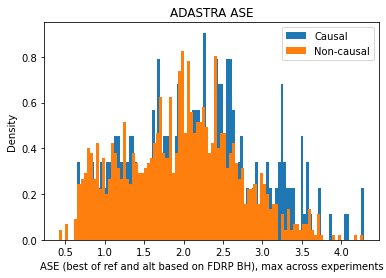

In [148]:
plt.hist(variants_annotated.query("label == True")["ASE_best"], bins=100, density=True, label="Causal")
plt.hist(variants_annotated.query("label == False")["ASE_best"], bins=100, density=True, label="Non-causal")
plt.xlabel("ASE (best of ref and alt based on FDRP BH), max across experiments")
plt.ylabel("Density")
plt.title("ADASTRA ASE")
plt.legend()
plt.show()

In [149]:
print ("Original ratio: Non-casual:causal = 9:1")
print ("Ovarlapping ADASTRA:")
variants_annotated["label"].value_counts()



Original ratio: Non-casual:causal = 9:1
Ovarlapping ADASTRA:


False    1163
True      243
Name: label, dtype: int64

## UDACHA

In [ ]:
!unzip data/UDACHA_IceKing_May2023_release.zip -d data/UDACHA_IceKing_May2023_release
!ls -l data/UDACHA_IceKing_May2023_release

Archive:  data/UDACHA_IceKing_May2023_release.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of data/UDACHA_IceKing_May2023_release.zip or
        data/UDACHA_IceKing_May2023_release.zip.zip, and cannot find data/UDACHA_IceKing_May2023_release.zip.ZIP, period.
ls: cannot access 'data/UDACHA_IceKing_May2023_release': No such file or directory


## Load model

In [ ]:
# Wrapper to compute a VEP score
class ModelVEP(torch.nn.Module):
	def __init__(self, model_path):
		super().__init__()
		self.model = AutoModel.from_pretrained(
			model_path,
			trust_remote_code=True,
		)

	def forward(
		self,
		input_ids_ref=None,
		input_ids_alt=None,
	):
		embed_ref = self.model(input_ids=input_ids_ref).last_hidden_state.reshape(len(input_ids_ref), -1)
		embed_alt = self.model(input_ids=input_ids_alt).last_hidden_state.reshape(len(input_ids_ref), -1)
		return F.pairwise_distance(embed_ref, embed_alt)


class ModelVEPAverageRC(torch.nn.Module):
	def __init__(self, model_path):
		super().__init__()
		self.model = AutoModel.from_pretrained(
			model_path,
			trust_remote_code=True,
		)

	def get_scores(self, input_ids_ref, input_ids_alt):
		embed_ref = self.model(input_ids=input_ids_ref).last_hidden_state.reshape(len(input_ids_ref), -1)
		embed_alt = self.model(input_ids=input_ids_alt).last_hidden_state.reshape(len(input_ids_ref), -1)
		return F.pairwise_distance(embed_ref, embed_alt)

	def forward(
		self,
		input_ids_ref_fwd=None,
		input_ids_alt_fwd=None,
		input_ids_ref_rev=None,
		input_ids_alt_rev=None,
	):
		fwd = self.get_scores(input_ids_ref_fwd, input_ids_alt_fwd)
		rev = self.get_scores(input_ids_ref_rev, input_ids_alt_rev)
		return (fwd + rev) / 2

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_path)
window_size = 512
if average_rc:
	model = ModelVEPAverageRC(model_path)
else:
	model = ModelVEP(model_path)

## Tokenize dataset

In [ ]:
class Genome:
	def __init__(self, path):
		self.data = Fasta(fsspec.open(path, anon=True))

	def __call__(self, chrom, start, end, strand="+"):
		res = self.data[chrom][start:end]
		if strand == "-":
			res = res.reverse.complement
		return str(res)

In [ ]:
genome = Genome("s3://broad-references/hg38/v0/Homo_sapiens_assembly38.fasta")

In [ ]:
def tokenize(seqs):
	return tokenizer(
		seqs,
		padding=False,
		truncation=False,
		return_token_type_ids=False,
		return_attention_mask=False,
		return_special_tokens_mask=False,
		return_tensors="pt",
	)["input_ids"]

def get_tokenized_seq(vs):
	# we convert from 1-based coordinate (standard in VCF) to
	# 0-based, to use with Genome
	chrom = np.array(vs["chrom"])
	n = len(chrom)
	pos = np.array(vs["pos"]) - 1
	start = pos - window_size // 2
	end = pos + window_size // 2
	seq_fwd = [genome("chr" + chrom[i], start[i], end[i]) for i in range(n)]
	seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
	assert seq_fwd.shape[1] == window_size
	ref_fwd = np.array(vs["ref"])
	alt_fwd = np.array(vs["alt"])
	pos_fwd = window_size // 2

	def prepare_output(seq, pos, ref, alt):
		assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
		seq_ref = seq
		seq_alt = seq.copy()
		seq_alt[:, pos] = alt
		return (
			tokenize(["".join(x) for x in seq_ref]),
			tokenize(["".join(x) for x in seq_alt]),
		)

	res = {}
	res["input_ids_ref"], res["input_ids_alt"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
	return res

def get_tokenized_seq_average_rc(vs):
	# we convert from 1-based coordinate (standard in VCF) to
	# 0-based, to use with Genome
	chrom = np.array(vs["chrom"])
	n = len(chrom)
	pos = np.array(vs["pos"]) - 1
	start = pos - window_size // 2
	end = pos + window_size // 2
	seq_fwd = [genome("chr" + chrom[i], start[i], end[i]) for i in range(n)]
	seq_rev = [str(Seq(x).reverse_complement()) for x in seq_fwd]
	seq_fwd = np.array([list(seq.upper()) for seq in seq_fwd], dtype="object")
	seq_rev = np.array([list(seq.upper()) for seq in seq_rev], dtype="object")
	assert seq_fwd.shape[1] == window_size
	assert seq_rev.shape[1] == window_size
	ref_fwd = np.array(vs["ref"])
	alt_fwd = np.array(vs["alt"])
	ref_rev = np.array([str(Seq(x).reverse_complement()) for x in ref_fwd])
	alt_rev = np.array([str(Seq(x).reverse_complement()) for x in alt_fwd])
	pos_fwd = window_size // 2
	pos_rev = pos_fwd - 1 if window_size % 2 == 0 else pos_fwd

	def prepare_output(seq, pos, ref, alt):
		assert (seq[:, pos] == ref).all(), f"{seq[:, pos]}, {ref}"
		seq_ref = seq
		seq_alt = seq.copy()
		seq_alt[:, pos] = alt
		return (
			tokenize(["".join(x) for x in seq_ref]),
			tokenize(["".join(x) for x in seq_alt]),
		)

	res = {}
	res["input_ids_ref_fwd"], res["input_ids_alt_fwd"] = prepare_output(seq_fwd, pos_fwd, ref_fwd, alt_fwd)
	res["input_ids_ref_rev"], res["input_ids_alt_rev"] = prepare_output(seq_rev, pos_rev, ref_rev, alt_rev)
	return res

In [ ]:
if average_rc:
	dataset.set_transform(get_tokenized_seq_average_rc)
else:
	dataset.set_transform(get_tokenized_seq)

In [ ]:
dataset[0]

## Run inference

In [ ]:
training_args = TrainingArguments(
	output_dir=tempfile.TemporaryDirectory().name,
	per_device_eval_batch_size=128,
	# pyfaidx does not allow multiple workers
	# for longer jobs you can use the gpn.data.Genome class,
	# which loads a local fasta file into memory and can use multiple
	# workers, see e.g.
	# https://github.com/songlab-cal/gpn/blob/main/gpn/ss/run_vep_embed_dist.py
	dataloader_num_workers=0,
	remove_unused_columns=False,
	torch_compile=False,
	fp16=True,
	report_to="none",
)
trainer = Trainer(model=model, args=training_args)
preds = trainer.predict(test_dataset=dataset).predictions
preds.shape

## Compute metrics

In [ ]:
V["score"] = preds

In [ ]:
# let's compare to the precomputed scores
# this is using RC averaging
V["precomputed_score"] = pd.read_parquet("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/features/GPN_final_EuclideanDistance.parquet").score.values
V[["score", "precomputed_score"]].corr()

In [ ]:
plt.figure(figsize=(2, 2))
sns.histplot(
	data=V, x="score", bins=30, hue="label", stat="density",
	common_norm=False, common_bins=True,
)
sns.despine();

In [ ]:
# global AUPRC
average_precision_score(V.label, V.score)

In [ ]:
# AUPRC by chrom
res_by_chrom = []
for chrom in V.chrom.unique():
	V_chrom = V[V.chrom == chrom]
	res_by_chrom.append([chrom, len(V_chrom), average_precision_score(V_chrom.label, V_chrom.score)])
res_by_chrom = pd.DataFrame(res_by_chrom, columns=["chrom", "n", "AUPRC"])
res_by_chrom

In [ ]:
# Weighted average

def stat(df):
	weight = df["n"] / df["n"].sum()
	return (df["AUPRC"] * weight).sum()

stat(res_by_chrom)

In [ ]:
def bootstrap_se(df, stat, n_bootstraps=1000):
	df = pl.DataFrame(df)
	return (
		pl.Series([
			stat(df.sample(len(df), with_replacement=True, seed=i))
			for i in range(n_bootstraps)]
		)
		.std()
	)

bootstrap_se(res_by_chrom, stat)

In [ ]:
# compare with official results (which use RC averaging)
pd.read_csv("hf://datasets/songlab/TraitGym/mendelian_traits_matched_9/AUPRC_by_chrom_weighted_average/all/GPN_final_EuclideanDistance.plus.score.csv")